In [1]:
#@markdown #Step 0 Motion Correction: Run this cell to select a raw, unregistered dataset from gdrive (or opt to use the dataset we provide, using the "use_demo_dataset" below)
use_demo_dataset = False #@param {type:"boolean"}

import os
from IPython.display import display
import ipywidgets
from ipywidgets import widgets, interactive
from ipyfilechooser import FileChooser

load_from_gdrive = False #@param {type:"boolean"}

if load_from_gdrive:
  from google.colab import output
  output.enable_custom_widget_manager()
  from google.colab import drive
  import gdown
  drive.mount('/content/gdrive', force_remount=True)

if not use_demo_dataset:
  print("Select the file you want to analyze using the browser below")
  fc = FileChooser('')

  # Create and display a FileChooser widget
  fc = FileChooser('')
  display(fc)
else:
  print("You opted to use the demo dataset. \n Select a folder in your gdrive where you'd like to store the results")

  fc = FileChooser('')

  # Create and display a FileChooser widget
  fc = FileChooser('')
  display(fc)




Select the file you want to analyze using the browser below


FileChooser(path='/data/home/app2139/masknmf_full_pipeline', filename='', title='', show_hidden=False, select_…

# Motion Correction and File Preprocessing documentation. You can set parameters in the box below this one

Documentation: 
0. **register**: If you want to run registration, set this to true. Otherwise, set this to false. However, this panel must be run either way. 
1. Local
  - **devel**: Motion correction runs iteratively, applying rigid correction (often several times in sequence) followed by an optional piecewise-rigid correction step. The intermediate results are often stored, which means the data is duplicated. If this is a problem, set 'devel' : False, and data that is no longer needed will be deleted (including the original input file!). Only do this if you plan to run the algorithm exactly once. Otherwise, if 'devel' : True, the code will run in "development" mode, which means nothing is deleted so you can re-run multiple times with different parameters and play around with the algorithm. 

2. Caiman
  - **dxy**: Tuple of ints, for e.g. (1., 1.). This parameter describes the spatial resolution of the dataset in each dimension, in um per pixel. 
  - **max_shift_um**: Tuple of ints, for e.g. (3., 3.). This parameter describes the maximum allowed rigid shift in micrometers (um). 
    - KEY: To get the maximum allowed rigid shift in *pixels*, simply divide the elements of 'dxy' by the corresponding elements of 'max_shift_um'. For example, if 'dxy' = (2, 3) and max_shift_um = (8, 9), then the max allowed shift in each dimension is (8/2, 9/3) = (4, 3).
  - **max_deviation_rigid**: Int, for e.g. 3. Describes the maximum deviation for patches with respect to rigid shifts.
  - **patch_motion_um**: Tuple of ints, for e.g. (30., 40.). This parameter is only used if you run piecewise rigid (aka nonrigid) motion correction. It describes the size (in um) of each "subpatch" of the FOV on which we run piecewise rigid registation. 
    - KEY: To get the equivalent size in pixels (as opposed to um), simply divide the elements of patch_motion_um by the corresponding elements of 'dxy'. For example, if patch_motion_um is (60, 80) and 'dxy' is (2, 1), then the FOV is divided into (60/2, 80/1) = (30, 80)-sized subpatches. 
  - **overlaps**: Tuple of ints, for e.g. (5., 5.). This parameter describes the number of pixels of overlap (in the x and y dimensions) between subpatches when running piecewise rigid motion correction.
  - **border_nan**: Always has value 'copy'. Parameter used to handle border values for motion correction. Do not change this. 
  - **niter_rig**: Int, for e.g. 4. Number of times to apply rigid registration (sequentially) to the dataset. 4 is a good default value here, though perhaps possible to set a lower number of iterations (1, 2 or 3). 
  - **pw_rigid**: True or False. This parameter is a flag used to indicate whether you want to run piecewise rigid registration (after running rigid registration). 
  - **gSig_filt**: By default None, otherwise tuple of ints, for e.g. (5., 5.). For certain dataset (1p imaging) it helps to high pass filter the data, then estimate shifts, and apply those shifts to the original data. In that case, gSig_filt provides parameters used to specify a Gaussian Kernel, which we evenually modify and use to high pass filter the data.
  - **splits**: Int, for example 2000. This algorithm operates on temporal subsets of the data at a time. **splits** specifies how large this temporal subuset is. Note that if the temporal subset is too small, the estimated template might not be good. Rule of thumb: set splits to be at least 200. On the other hand, if using a GPU on Colab, you might run into memory issues if splits is too large (due to memory constraints of GPU). If so, just reduce splits slightly. Good default values: between 200 and 400. 
  - **frames_per_split**: Int, default value 5000. Number of frames of data that are loaded into RAM at a time. 

3. Output
  - **save_movie**: True or False. Motion correction outputs generates 2 things: (1) A set of shifts to apply to each frame and (2) the corrected movie. This flag indicates whether or not to save the corrected movie. 
  - **dtype**: If save_movie is True, this flag describes the intended dtype of the output (int16, float32, etc.).



In [2]:
#@markdown #Step 1 File Preprocessing and Motion Correction: Specify parameters and run motion correction algorithm (see documentation above)
# #NOTE: this data folder will also contain the location of the TestData
data_folder = fc.selected_path
input_file = fc.selected

from datetime import datetime


def get_shape(filename):
  import tifffile
  with tifffile.TiffFile(filename) as tffl:
      num_frames = len(tffl.pages)
      for page in tffl.pages[0:1]:
          image = page.asarray()
          x, y = page.shape
  return (x,y,num_frames)

def get_file_name(filestring):
  splitted_values = filestring.split("/")[-1]
  name_value = splitted_values.split(".")[0]
  return name_value

def define_new_folder(filestring):
  filename = get_file_name(filestring)
  now = datetime.now()
  
  # dd/mm/YY H:M:S
  dt_string = now.strftime(filename + "_results_%d_%m_%Y_%H_%M_%S")
  print(dt_string)	
  return dt_string


def set_and_create_folder_path(input_file, data_folder):
  new_folder_name = define_new_folder(input_file)
  final_path = os.path.join(data_folder, new_folder_name)
  if not os.path.exists(final_path):
    os.mkdir(final_path)
    print("creating folder at location {} in gdrive".format(final_path))
  return final_path

data_folder = set_and_create_folder_path(fc.selected, fc.selected_path)


import shutil
if not use_demo_dataset: 
  #NOTE: this data folder will also contain the location of the TestData
  data_folder = set_and_create_folder_path(fc.selected, fc.selected_path)
  input_file = fc.selected 

if use_demo_dataset:
  data_folder = fc.selected_path
  file_url = "https://drive.google.com/uc?id={}".format("16eDNcZXuKRBkmOMEdoL1oAipMYIK_z8w")
  output = "demoMovie.tif"
  input_file = os.path.join(data_folder, output)
  gdown.download(file_url, output, quiet=False)
  shutil.move(output, input_file)
  data_folder = set_and_create_folder_path(fc.selected, input_file)
  print("We downloaded the demo data and moved it to {}".format(input_file))


register = False #@param {type:"boolean"}
# devel = True #@param {type:"boolean"}
devel = True #never delete uploaded data

dx = 2 #@param {type:"slider", min:0, max:100, step:1}
dy = 2 #@param {type:"slider", min:0, max:100, step:1}

dxy = (dx, dy)

max_shift_in_um_xdimension = 50 #@param {type:"slider", min:0, max:200, step:1}
max_shift_in_um_ydimension = 50 #@param {type:"slider", min:0, max:200, step:1}

max_shift_um = (max_shift_in_um_xdimension, max_shift_in_um_ydimension)

max_deviation_rigid = 5 #@param {type:"slider", min:0, max:100, step:1}

patch_motion_um_x = 17 #@param {type:"slider", min:0, max:200, step:1}
patch_motion_um_y = 17 #@param {type:"slider", min:0, max:200, step:1}

patch_motion_um = (patch_motion_um_x, patch_motion_um_y)

overlaps_x = 24 #@param {type:"slider", min:0, max:200, step:1}
overlaps_y = 24 #@param {type:"slider", min:0, max:200, step:1}

overlaps = (overlaps_x, overlaps_y)

border_nan = 'copy'

niter_rig = 2 #@param {type:"slider", min:1, max:10, step:1}
niter_els = 2 #@param {type:"slider", min:1, max:10, step:1}

pw_rigid = True #@param {type:"boolean"}

use_gSig_filt = False #@param {type:"boolean"}
gSig_filt_x = 3 #@param {type:"slider", min:0, max:30, step:1}
gSig_filt_y = 3 #@param {type:"slider", min:0, max:30, step:1}

sketch_template = True

if use_gSig_filt: 
  gSig_filt = (gSig_filt_x, gSig_filt_y)
else:
  gSig_filt = None

frames_per_split =  500
# frames_per_split = 200

INPUT_PARAMS = {
    # Caiman Internal:
    'local': {'devel': devel},
    'caiman': {'dxy': dxy,
               'max_shift_um': max_shift_um,
               'max_deviation_rigid': max_deviation_rigid,
               'patch_motion_um': patch_motion_um,
               'overlaps': overlaps,
               'border_nan': 'copy',
               'niter_rig': niter_rig,
               'niter_els': niter_els,
               'pw_rigid': pw_rigid,
               'gSig_filt': gSig_filt,
               'splits' : frames_per_split,
               'sketch_template': True},
}


import multiprocessing
import os
import shutil
import pathlib
import sys
import math
import glob

import numpy as np
import tifffile

import datetime



from tqdm import tqdm

import yaml



def display(msg):
    """
    Printing utility that logs time and flushes.
    """
    tag = '[' + datetime.datetime.today().strftime('%y-%m-%d %H:%M:%S') + ']: '
    sys.stdout.write(tag + msg + '\n')
    sys.stdout.flush()

def parinit():
    """
    Initializer run by each process in multiprocessing pool.
    """
    os.environ['MKL_NUM_THREADS'] = "1"
    os.environ['OMP_NUM_THREADS'] = "1"
    os.environ['OPENBLAS_NUM_THREADS'] = '1'
    num_cpu = multiprocessing.cpu_count()
    os.system('taskset -cp 0-%d %s > /dev/null' % (num_cpu, os.getpid()))


def runpar(function, arguments, nproc=None, **kwargs):
    """
    Maps an input function to a sequence of arguments.
    """
    if nproc is None:
        nproc = multiprocessing.cpu_count()
    with multiprocessing.Pool(initializer=parinit, processes=nproc) as pool:
        res = pool.map(functools.partial(function, **kwargs), arguments)
    pool.join()
    return res


def flatten(mapping):
    """
    Flattens a nested dictionary assuming that there are no key collisions.
    """
    items = []
    for key, val in mapping.items():
        if isinstance(val, dict):
            items.extend(flatten(val).items())
        else:
            items.append((key, val))
    return dict(items)


def load_config(default):
    """
    Loads user-provided yaml file containing parameters key-value pairs.
    Omitted optional parameter keys are filled with default values.
    Parameters
    ----------
    filename : string
        Full path + name of config 'yaml' file.
    Returns
    -------
    params : dict
        Parameter key-value pairs.
    """

    params = dict()
    # Insert default values for missing optional fields
    display('Inserting defaults for missing optional arguments')
    for group, group_params in default.items():
        display(f"Using all defaults in group '{group}={group_params}'")
        params[group] = group_params
    display("Config file successfully loaded.")
    return flatten(params)


def write_params(filename, required={}, default={}, **params):
    """
    Writes verbose parameter dictionary containing all default, modified, and
    simulated fields to a specified output location.
    Parameters
    ----------
    filename : string
        Full path + name for destination of output config file.
    params : dict
        User-provided parameter key-value pairs to be written.
    Returns
    -------
    None :
    """

    # Construct Mapping Of Keys -> Categories
    reverse_map = {}
    for group, keys in required.items():
        for key in keys:
            reverse_map[key] = group
    for group, group_params in default.items():
        for key, _ in group_params.items():
            reverse_map[key] = group

    # Undo Flattening
    grouped_params = {'unused': {}}
    for group, _ in required.items():
        grouped_params[group] = {}
    for group, _ in default.items():
        grouped_params[group] = {}
    for key, val in params.items():
        try:
            grouped_params[reverse_map[key]][key] = val
        except KeyError:
            grouped_params['unused'][key] = val

    # Write Output
    display(f"Writing verbose config to ({filename})...")
    with open(filename, 'w') as stream:
        yaml.dump(grouped_params, stream, default_flow_style=False)
    display("Verbose config written successfully.")






DATA_WRITERS = {
    'tiff': tifffile.imwrite,
    'tif': tifffile.imwrite
}
VALID_EXTS = list(DATA_WRITERS.keys())
CONFIG_NAME = 'config.yaml'


def get_caiman_memmap_shape(filename):
    fn_without_path = os.path.split(filename)[-1]
    fpart = fn_without_path.split('_')[1:-1]  # The filename encodes the structure of the map
    d1, d2, d3, T, order = int(fpart[-9]), int(fpart[-7]), int(fpart[-5]), int(fpart[-1]), fpart[-3]
    return (d1, d2, T)


def write_output_simple(targets, out_file, batch_size = 1000, dtype = np.float64):   
    from jnormcorre.utils.movies import load
    with tifffile.TiffWriter(out_file, bigtiff=True) as tffw:
        for index in tqdm(range(len(targets))):
            file = targets[index]
            file_split = file.rsplit(".", maxsplit=1)
            shape = get_caiman_memmap_shape(file)
            num_iters = math.ceil(shape[2] / batch_size)
            for k in range(num_iters):
                start = k*batch_size
                end = min((k+1)*batch_size, shape[2])
                data = load(file, subindices=range(start, end)).astype(dtype)
                for j in range(min(end - start, batch_size)):
                    tffw.write(data[j, :, :], contiguous=True)           


def chunk_singlepage_data(filename, batch_size = 10000):
    '''
    Saves singlepage tiff files as a sequence of multipage tifs
    Code adapted from @JakeHeffley
    
    Params: 
        filename: str. String describing the path to the data file
        batch_size: int. Number of frames to save in each multipage tif
    '''
    
    filename_list = []
    total_count = 0
    
    with tifffile.TiffFile(filename) as tffl:
        T = tffl.series[0].shape[0] #total number of frames in original movie
        batch_size = T
        iters = math.ceil(T/batch_size)

        
        full_movie = tffl.asarray(out='memmap')
        
        for i in tqdm(range(iters)):
            start = i * batch_size
            end = min((i+1) * (batch_size), T)
                
            fileparts = filename.rsplit(".", maxsplit=1)
            this_batch = full_movie[start:end, :, :]
            
            #Add filename to name list
            new_filename = os.path.join(fileparts[0] + "_" + str(total_count) + "." + fileparts[1])
            tifffile.imsave(new_filename, this_batch)
            filename_list.append(new_filename)
            total_count += 1
     
    #As last step, delete original data
    return filename_list
 
def delete_targets(targets):
    display("DELETING TARGETS")
    for file in targets:
        os.remove(file)
    

def resolve_dataformats(filename):
    '''
    Function for managing bad data formats (such as single-page tif files) which are tough to load. Resolves these issues by loading the data into memmap format and then saving the data (in small batches) into a better format
    Input: 
        filename: str. String describing the full filepath of the datafile
    Returns: 
        file_output: list of strings. In this list, each string is a filename. These files, taken together, form the entire dataset
    '''
    _, extension = os.path.splitext(filename)[:2]
    if extension in ['.tif', '.tiff', '.btf']:  # load tif file
        with tifffile.TiffFile(filename) as tffl:
            multi_page = True if tffl.series[0].shape[0] > 1 else False
            if len(tffl.pages) == 1:
                display("Data is saved as single page tiff file. We will re-save data as sequence of smaller tifs to improve performance, but this will take time. To avoid this issue, save your data as multi-page tiff files")
                file_output = chunk_singlepage_data(filename)
                return file_output

    file_output = [filename]
    return file_output


def motion_correct(filename,
                   outdir,
                   dxy = (2., 2.),
                   max_shift_um = (12., 12.),
                   max_deviation_rigid = 3,
                   patch_motion_um = (100., 100.),
                   overlaps = (24, 24),
                   border_nan= 'copy',
                   niter_rig = 4,
                   splits=200,
                   pw_rigid = True,
                   gSig_filt=None,
                   save_movie=True,
                   dtype='int16',
                   sketch_template=False,
                   **params):
    """
    Runs motion correction from caiman on the input dataset with the
    option to process the same dataset in multiple passes.
    Parameters
    ----------
    filename : string
        Full path + name for destination of output config file.
    outdir : string
        Full path to location where outputs should be written.
    dxy: tuple (2 elements)
        Spatial resolution in x and y in (um per pixel)
    max_shift_um: tuple (2 elements)
        Maximum shift in um
    max_deviation_rigid: int
        Maximum deviation allowed for patch with respect to rigid shifts
    patch_motion_um: 
        Patch size for non rigid correction in um
    overlaps:
        Overlap between patches
    border_nan: 
        See linked caiman docs for details
    niter_rig: int
        Number of passes of rigid motion correction (used to estimate template)
    splits: int
        We divide the registration into chunks (temporally). Splits = number of frames in each chunk. So splits = 200 means we break the data into chunks, each containing ~200 frames.
    pw_rigid: boolean 
        Indicates whether or not to run piecewise rigid motion correction
    devel: boolean
        Indicates whether this code is run in development mode. If in development mode, the original data is not deleted.
    Returns
    -------
    None :
    """

    from jnormcorre.utils.movies import load
    from jnormcorre import motion_correction
    import math

    print("the value of niter_rig is {}".format(niter_rig))

    # Iteratively Run MC On Input File
    display("Running motion correction...")
    target = resolve_dataformats(filename)

    total_frames_firstfile = get_shape(target[0])[2]
    splits = math.ceil(total_frames_firstfile / splits)
    display("Number of chunks is {}".format(splits))
    
    # Since running on colab, which has only 2 vCPU, don't use multiprocessing, use GPU or TPU since the main compute is implemented in jax
    dview=None
    
    
    # Default MC_dict
    mc_dict = {
    'border_nan': 'copy',               # flag for allowing NaN in the boundaries
    'max_deviation_rigid': 3,           # maximum deviation between rigid and non-rigid
    'max_shifts': (6, 6),               # maximum shifts per dimension (in pixels)
    'min_mov': None,                    # minimum value of movie
    'niter_rig': 4,                     # number of iterations rigid motion correction
    'niter_els': 1,                     # number of iterations of piecewise rigid motion correction
    'nonneg_movie': True,               # flag for producing a non-negative movie
    'num_frames_split': 80,             # split across time every x frames
    'num_splits_to_process_els': None,  # The number of splits of the data which we use to estimate the template for the rigid motion correction. If none, we look at entire dataset.
    'num_splits_to_process_rig': None,  # The number of splits of the data which we use to estimate the template for pwrigid motion correction. If none, we look at entire dataset.
    'overlaps': (32, 32),               # overlap between patches in pw-rigid motion correction
    'pw_rigid': False,                  # flag for performing pw-rigid motion correction
    'shifts_opencv': True,              # flag for applying shifts using cubic interpolation (otherwise FFT)
    'splits_els': 14,                   # number of splits across time for pw-rigid registration
    'splits_rig': 14,                   # number of splits across time for rigid registration
    'strides': (96, 96),                # how often to start a new patch in pw-rigid registration
    'upsample_factor_grid': 4,          # motion field upsampling factor during FFT shifts
    'indices': (slice(None), slice(None)),  # part of FOV to be corrected
    'gSig_filt': None
}

    max_shifts = [int(a/b) for a, b in zip(max_shift_um, dxy)]
    strides = tuple([int(a/b) for a, b in zip(patch_motion_um, dxy)])
    
    mc_dict['pw_rigid']= pw_rigid
    mc_dict['strides'] = strides
    mc_dict['overlaps'] = overlaps
    mc_dict['max_deviation_rigid'] = max_deviation_rigid
    mc_dict['border_nan'] = 'copy'
    mc_dict['niter_rig'] = niter_rig
    mc_dict['niter_els'] = niter_els
    if sketch_template:
        mc_dict['num_splits_to_process_els'] = 5
        mc_dict['num_splits_to_process_rig'] = 5
    mc_dict['gSig_filt'] = gSig_filt
    mc_dict['max_shifts'] = max_shifts
    mc_dict['splits_els'] = splits
    mc_dict['splits_rig'] = splits
    
    print("THE MC DICT IS {}".format(mc_dict))

    
    corrector = motion_correction.MotionCorrect(target, dview=dview, **mc_dict)
    
    # Run MC, Always Saving Non-Final Outputs For Use In Next Iteration
    corrector_obj = corrector.motion_correct(
        save_movie=False
    )
    

    # target = corrector.target_file

    
    display("Motion correction completed.")


    # Save Frame-wise Shifts
    display(f"Saving computed shifts to ({outdir})...")
    np.savez(os.path.join(outdir, "shifts.npz"),
             shifts_rig=corrector.shifts_rig,
             x_shifts_els=corrector.x_shifts_els if pw_rigid else None,
             y_shifts_els=corrector.y_shifts_els if pw_rigid else None)
    display('Shifts saved as "shifts.npz".')


    return corrector_obj, target


# Get data and config filenames from cmd line args
data_name = input_file
outdir = data_folder
pathlib.Path(outdir).mkdir(parents=True, exist_ok=True)

# Load User-Provided Params
params = load_config(INPUT_PARAMS)
print(params)
write_params(os.path.join(outdir, "MotionCorrectConfig.yaml"),
              default=INPUT_PARAMS,
              **params)


# %load_ext line_profiler
# Run Single Pass Motion Correction
try:
  if register:
    corrector, target = motion_correct(data_name, outdir, **params)
    data_name = target[0]
    input_file = data_name
  else:
    corrector = None
    data_name = resolve_dataformats(data_name)[0]
    input_file = data_name
  import jax
  jax.clear_backends()
except Exception as e:
  print(e)
  display("Program crashed.")
  import jax
  jax.clear_backends()

motion_corrected_support_temporal_crop_results_13_01_2023_03_24_25
creating folder at location /data/home/app2139/masknmf_full_pipeline/datasets/KAIST_support/motion_corrected_support_temporal_crop_results_13_01_2023_03_24_25 in gdrive
motion_corrected_support_temporal_crop_results_13_01_2023_03_24_25
[23-01-13 03:24:25]: Inserting defaults for missing optional arguments
[23-01-13 03:24:25]: Using all defaults in group 'local={'devel': True}'
[23-01-13 03:24:25]: Using all defaults in group 'caiman={'dxy': (2, 2), 'max_shift_um': (50, 50), 'max_deviation_rigid': 5, 'patch_motion_um': (17, 17), 'overlaps': (24, 24), 'border_nan': 'copy', 'niter_rig': 2, 'niter_els': 2, 'pw_rigid': True, 'gSig_filt': None, 'splits': 500, 'sketch_template': True}'
[23-01-13 03:24:25]: Config file successfully loaded.
{'devel': True, 'dxy': (2, 2), 'max_shift_um': (50, 50), 'max_deviation_rigid': 5, 'patch_motion_um': (17, 17), 'overlaps': (24, 24), 'border_nan': 'copy', 'niter_rig': 2, 'niter_els': 2, 'pw

In [3]:
#@markdown #(Optional) Visualize motion correction results (sanity check)
from localnmf.visualization  import write_mpl_no_compress_comparisons
import tifffile 
import matplotlib.pyplot as plt

if register:
  start = 0 #@param {type:"slider", min:0, max:100000, step:1}
  end = 368 #@param {type:"slider", min:0, max:100000, step:1}
  if end < start+10:
    print("start and end are incorrectly set or too close together. Generating movie for frames 0 through 100 (default)")
    start = 0 
    end = 100
  #Get motion corrected data: 
  frames = [i for i in range(start, end)]

  original_data = tifffile.imread(input_file, key=frames)
  corrector.batching = 10
  corrected_data = corrector.register_frames(original_data.astype("float"))
  corrected_data = np.concatenate(corrected_data, axis = 0).transpose(1,2,0)
  original_data = original_data.transpose(1,2,0)

  template_movie = corrector.template[:, :, None] + np.zeros((corrector.template.shape[0], corrector.template.shape[1], corrected_data.shape[2]))

  mean_movie = np.mean(original_data, axis = 2, keepdims=True) + np.zeros((corrector.template.shape[0], corrector.template.shape[1], corrected_data.shape[2]))


  if np.amax(template_movie) != 0:
    template_movie /= np.amax(template_movie)
  if np.amax(mean_movie) != 0:
    mean_movie /= np.amax(mean_movie)
  mov_list = [corrected_data, original_data, template_movie, mean_movie]
  img_types = [1,1,1,1]
  titles = ["Motion Corrected", "Original", "Estimated Template", "Unregistered Mean Img"]
  movie_scales = [99, 99, 99, 99]

  import matplotlib.pyplot as plt



  output_fname = "MotionCorrectionDiagnostic"
  import os
  import shutil
  try:
    if os.path.exists("tmp"):
      shutil.rmtree("tmp")
      display("Deleted existing tmp folder")
    display("You chose to generate a video over {} frames. A reasonable frame range (end - start) is between 200 and 600".format(len(frames)))

    write_mpl_no_compress_comparisons(mov_list, 
                  output_fname, img_types, movie_scales, fr=30, titles=titles)

    final_destination = os.path.join(data_folder, output_fname + ".mp4")
    if os.path.isfile(final_destination):
      os.remove(final_destination)
      print("deleted file at location {} before moving the new diagnostic video of the same name to this location")
    shutil.move(output_fname + ".mp4", data_folder)
    print("the diagnostic video is now available at {} in your google drive".format(final_destination))
  except:
    display("Error encountered")
    if os.path.exists("tmp"):
      shutil.rmtree("tmp")
    display("We removed the tmp directory used to generate the movie. You can run this panel again now to generate the movie")

else:
  display("Motion correction was never run, go back to that panel and set register to True and run again")


[22-12-19 06:24:13]: You chose to generate a video over 368 frames. A reasonable frame range (end - start) is between 200 and 600
we are clipping this movie at value 4263.056186523443
we are clipping this movie at value 4792.0
we are clipping this movie at value 0.5831062345935135
we are clipping this movie at value 0.49077163921870204
the CPU affinity BEFORE runpar is 24
the number of processes is 24
pid 7360's current affinity list: 0
pid 7360's new affinity list: 0-23
pid 7361's current affinity list: 0
pid 7361's new affinity list: 0-23
pid 7363's current affinity list: 0
pid 7363's new affinity list: 0-23
pid 7364's current affinity list: 0
pid 7364's new affinity list: 0-23
pid 7365's current affinity list: 0
pid 7365's new affinity list: 0-23
pid 7368's current affinity list: 0
pid 7368's new affinity list: 0-23
pid 7369's current affinity list: 0
pid 7369's new affinity list: 0-23
pid 7372's current affinity list: 0
pid 7372's new affinity list: 0-23
pid 7370's current affinity

ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libsw

the diagnostic video is now available at /data/home/app2139/masknmf_full_pipeline/datasets/fov1_z-400_bessel_tuning_crop_results_19_12_2022_06_23_17/MotionCorrectionDiagnostic.mp4 in your google drive


frame=  368 fps= 18 q=31.0 Lsize=    5298kB time=00:00:12.23 bitrate=3547.9kbits/s speed=0.589x    
video:5296kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.047006%


In [4]:
#@markdown #(Optional) Write out the full motion corrected data as a tiff file. For large data, this will take time

save_movie = True #@param {type:"boolean"}
dtype = "float32" #@param ["int16", "float32", "float64"] {allow-input: true}

def get_shape(filename):
  import tifffile
  with tifffile.TiffFile(filename) as tffl:
      num_frames = len(tffl.pages)
      for page in tffl.pages[0:1]:
          image = page.asarray()
          x, y = page.shape
  return (x,y,num_frames)

    
def write_output_simple(corrector, targets, out_file, batch_size = 1000, dtype = np.float64):   
    from tqdm import tqdm
    from jnormcorre.utils.movies import load
    import shutil 
    import os
    
    if os.path.exists(out_file):
        print("File already exists")
        os.remove(out_file)
    with tifffile.TiffWriter(out_file, bigtiff=True) as tffw:
        for index in range(len(targets)):
            file = targets[index]
            file_split = file.rsplit(".", maxsplit=1)
            shape = get_shape(file)
            num_iters = math.ceil(shape[2] / batch_size)
            for k in tqdm(range(num_iters)):
                start = k*batch_size
                end = min((k+1)*batch_size, shape[2])
                data = load(file, subindices=range(start, end)).astype(dtype)
                data_corrected = np.concatenate(corrector.register_frames(data.astype("float")), axis = 0)
                data_corrected = data_corrected.astype(dtype)
                for j in range(min(end - start, batch_size)):
                    tffw.write(data_corrected[j, :, :], contiguous=True)  

    
import os


out_file = os.path.join(outdir, "corrected_movie.tif")
if register:
  if save_movie:
      write_output_simple(corrector, [data_name], out_file=out_file, dtype=dtype)
else:
  display("Motion correction was never run, go back to that panel, set register to True and rerun")

100%|███████████████████████████████████████████| 29/29 [00:48<00:00,  1.69s/it]


#PMD Documentation:  

1. **block_height, block_width**: Positive integers divisible by 4. This algorithm performs truncated SVD on local (spatial) patches of the data. Conceptually, it breaks up the field of view into chunks of size (block_height, block_width, window_length); see window_length parameter below. 
  - **Key**: Set block_height, block_width to be roughly the size of a neuron soma


3. **overlaps_height, overlaps_width**: Positive integers; overlaps_height must be smaller than block_height, and overlaps_width must be smaller than block_width. As mentioned in 1. this algorithm breaks the FOV into local spatial patches. These spatial patches must overlap (so that when we put the patches back together, they can properly explain the full dataset without introducing line artifacts). The **overlaps_height** parameter describes how many pixels adjacent blocks overlap in the y dimension. The **overlaps_width** parameter describes how many pixels adjacent blocks overlap in the x dimension. 

4. **window_length**: Positive Integer; default 6000. LocalMD first identifies a linear subspace which contains the signal (and a modest amount of noise). This is a spatial basis for the compressed data. To estimate this compressed basis, we don't need to use the entire dataset; the first **window_length** frames are used instead. A default of 6000 works well in general. 

5. **background_rank**: Positive integer. **Currently not supported**. Default = 15. Before performing the LocalSVD algorithm, we first do an approximate rank-k truncated SVD on the entire dataset and temporally remove (subtract) this from the dataset. We then run localMD. Afterwards, we combine the results from the rank-k SVD and the localMD decomposition to produce our final matrix decomposition. In some cases, this approach (as opposed to just running localMD immediately) helps temporarily remove neuropil contamination so that localMD can better identify the signal subspace of the data. The **background_rank** parameter determines the rank (k) of the truncated SVD which we perform on the whole FOV.

6. **max_rank_per_block**: Positive integer. The maximum rank decomposition we use for each block of the FOV. This is normally 50, and should generally be unchanged. 

7. **run_deconv**: True or False. Whether or not we run the temporal sparsening (deconvolution) step necessary for maskNMF. **Should always be true unless you do not want to run maskNMF or just want get the compression outputs**



In [3]:
#@markdown #PMD: Specify the parameters for PMD algorithm. Main parameters to consider are block_height, block_width, and window_length. 


#NOTE: this data folder will also contain the location of the TestData
data_folder = outdir


block_height = 28 #@param {type:"slider", min:20, max:100, step:4}
block_width = 28 #@param {type:"slider", min:20, max:100, step:4}
block_sizes = [block_height, block_width]

overlaps_height = 5 #@param {type:"slider", min:0, max:100, step:1}
overlaps_width = 5 #@param {type:"slider", min:0, max:100, step:1}

if overlaps_height > block_height: 
  print("Overlaps height was set to be greater than block height, which is not valid")
  print("Setting overlaps to be 5")
  overlaps_height = 5

if overlaps_width > block_width:
  print("Overlaps width was set to be greater than width height, which is not valid \
  Setting overlaps to be 5")
  overlaps_width = 5

overlap = [overlaps_height, overlaps_width]


window_length = 6000 #@param {type:"integer"}
if window_length <= 0:
  print("Window length cannot be negative! Resetting to 6000")
  window_length = 6000
start = 0
end = window_length

# background_rank = 0
background_rank = 15 #@param {type:"slider", min:0, max:100, step:1}

# rank_prune_factor = 0.25 #@param {type:'slider', min:0, max:1, step:0.01}

# deconvolve=True #@param {type:'boolean'}
# deconv_batch=1000  #@param {type:'slider', min:1000, max:30000, step:1000}

###THESE PARAMS ARE NOT MODIFIED
# num_sims = 64
sim_conf = 5
max_rank_per_block = 40 #@param {type:"slider", min:5, max:50, step:1}

#@markdown Keep run_deconv true unless you do not want to run maskNMF demixing
run_deconv = False #@param {type:'boolean'}
deconv_batch = 1000
max_components = max_rank_per_block

INPUT_PARAMS = {
    # Caiman Internal:
    'localmd':{'block_height':block_height,
    'block_width':block_width,
    'overlaps_height':overlaps_height,
    'overlaps_width':overlaps_width,
    'window_length':window_length,
    'background_rank':background_rank,
    'max_rank_per_block':max_rank_per_block,
    'run_deconv':run_deconv 
    }
}



#---------------------------------------------#

##@markdown #Step 2 LocalMD: Run the matrix decomposition pipeline 

###IMPORTS


##TODO: Add apriori SVD option
block_sizes = block_sizes
overlap = overlap

def load_config(default):
    """
    Loads user-provided yaml file containing parameters key-value pairs.
    Omitted optional parameter keys are filled with default values.
    Parameters
    ----------
    filename : string
        Full path + name of config 'yaml' file.
    Returns
    -------
    params : dict
        Parameter key-value pairs.
    """

    params = dict()
    # Insert default values for missing optional fields
    display('Inserting defaults for missing optional arguments')
    for group, group_params in default.items():
        display(f"Using all defaults in group '{group}={group_params}'")
        params[group] = group_params
    display("Config file successfully loaded.")
    return flatten(params)


def write_params(filename, required={}, default={}, **params):
    """
    Writes verbose parameter dictionary containing all default, modified, and
    simulated fields to a specified output location.
    Parameters
    ----------
    filename : string
        Full path + name for destination of output config file.
    params : dict
        User-provided parameter key-value pairs to be written.
    Returns
    -------
    None :
    """

    # Construct Mapping Of Keys -> Categories
    reverse_map = {}
    for group, keys in required.items():
        for key in keys:
            reverse_map[key] = group
    for group, group_params in default.items():
        for key, _ in group_params.items():
            reverse_map[key] = group

    # Undo Flattening
    grouped_params = {'unused': {}}
    for group, _ in required.items():
        grouped_params[group] = {}
    for group, _ in default.items():
        grouped_params[group] = {}
    for key, val in params.items():
        try:
            grouped_params[reverse_map[key]][key] = val
        except KeyError:
            grouped_params['unused'][key] = val

    # Write Output
    display(f"Writing verbose config to ({filename})...")
    with open(filename, 'w') as stream:
        yaml.dump(grouped_params, stream, default_flow_style=False)
    display("Verbose config written successfully.")


def perform_localmd_pipeline(input_file, block_sizes, overlap, frame_range, background_rank, \
                        max_components, sim_conf, \
                         tiff_batch_size,deconv_batch, folder, run_deconv=True, pixel_batch_size=100,\
                        batching=5, dtype="float32",  order="F", corrector = None):
  
  from localmd.decomposition import localmd_decomposition, display
  from masknmf.engine.sparsify import get_factorized_projection
  import localmd.tiff_loader as tiff_loader
  import scipy
  import scipy.sparse
  import jax
  import jax.scipy
  import jax.numpy as jnp
  import numpy as np
  from jax import jit, vmap
  import functools
  from functools import partial
  import time

  start, end = frame_range[0], frame_range[1]

  #Reshape U using order="F" here
  U, R, s, V, tiff_loader_obj = localmd_decomposition(input_file, block_sizes, overlap, [start, end], \
                                    max_components=max_components, background_rank = background_rank, sim_conf=sim_conf,\
                                     tiff_batch_size=tiff_batch_size,pixel_batch_size=pixel_batch_size, batching=batching, dtype=dtype, order=order, \
                                     num_workers=0, frame_corrector_obj = corrector)


  ## Step 2h: Run deconvolution:
    
  ## GET RID OF THIS EVENTUALLY  
  downsample_factor = 1
  selected_indices = [downsample_factor*i for i in range(math.floor(V.shape[1]/downsample_factor))]
  V_sampled = V[:, selected_indices] 
  ## GET RID OF THIS EVENTUALLY
    
    
  limit = 20000
  if run_deconv:
    display("Running the deconvolution operation")
    np.savez("Deconvolution_Testing.npz", U=U, R=R, s=s, V=V, batch_size=deconv_batch, allow_pickle=True)
    deconv_components = get_factorized_projection(
          U,
          R,
          s[:, None] * V_sampled[:, :limit],
          batch_size=deconv_batch
      )
  else:
    display("WARNING: YOU ARE NOT USING THE DECONVOLUTION STEP, MASKNMF MAY NOT PERFORM AS WELL.")
    deconv_components = s[:, None] * V[:, :limit]


  def save_decomposition(U, R, s, V, deconvolved_temporal, load_obj, folder, order="F"):
    file_name = "decomposition.npz"
    final_path = os.path.join(folder, file_name)

    np.savez(final_path, fov_shape = load_obj.shape[:2], \
            fov_order=order, U_data = U.data, \
            U_indices = U.indices,\
            U_indptr=U.indptr, \
            U_shape = U.shape, \
            U_format = type(U), \
            R = R, \
            s = s, \
            Vt = V, \
            deconvolved_temporal=deconvolved_temporal, \
             mean_img = tiff_loader_obj.mean_img, \
             noise_var_img = tiff_loader_obj.std_img)
    
    display("the decomposition.npz file is saved at {}".format(folder))


  ##Step 2i: Save the results: 
  save_decomposition(U.tocsr(), R, s, V, deconv_components, tiff_loader_obj, folder, order=order)

  #Step 2j: Write the config to the outputs:



tiff_batch_size = 500
%load_ext line_profiler
try:
  import jax
  import torch
  jax.clear_backends()
  torch.cuda.empty_cache()
  params = load_config(INPUT_PARAMS)
  print(params)
  write_params(os.path.join(outdir, "CompressionConfig.yaml"),
                default=INPUT_PARAMS,
                **params)
    
  import localmd
  from localmd.decomposition import threshold_heuristic
  from localmd import tiff_loader
  from jnormcorre.motion_correction import frame_corrector 
  from masknmf.engine.sparsify import get_factorized_projection
  %lprun -f get_factorized_projection pmdresults = perform_localmd_pipeline(input_file, block_sizes, overlap, [start, end], background_rank, \
                          max_components, sim_conf, tiff_batch_size,deconv_batch,data_folder, pixel_batch_size=100, run_deconv=run_deconv,\
                          batching=5, dtype="float32",  order="F", corrector = corrector)
  torch.cuda.empty_cache()
  jax.clear_backends() 
except KeyboardInterrupt:
  print("\n \n \n")
  display("--------ERROR GENERATED, DETAILS BELOW-----")
  display("User ended the program execution. Manually clearing up memory to allow re-run of code.")
  import jax
  import torch
  jax.clear_backends()
  torch.cuda.empty_cache()
  display("Cleared memory")
except FileNotFoundError:
  print("\n \n \n")
  display("--------ERROR GENERATED, DETAILS BELOW-----")
  display("The file was not located. Please consider specifying the file again (step 0) and run the entire pipeline from the start\
  (Motion Correction)")
  import jax
  import torch
  jax.clear_backends()
  torch.cuda.empty_cache()
  display("Cleared memory")
except Exception as e:
  print("\n \n \n")
  display("--------ERROR GENERATED, DETAILS BELOW-----")
  display("Unexpected error, please report")
  import jax
  import torch
  jax.clear_backends()
  torch.cuda.empty_cache()
  display("Cleared backends")
  print(e)
  display("Please re-run the pipeline starting from motion correction.")

[23-01-13 03:24:30]: Inserting defaults for missing optional arguments
[23-01-13 03:24:30]: Using all defaults in group 'localmd={'block_height': 28, 'block_width': 28, 'overlaps_height': 5, 'overlaps_width': 5, 'window_length': 6000, 'background_rank': 15, 'max_rank_per_block': 40, 'run_deconv': False}'
[23-01-13 03:24:30]: Config file successfully loaded.
{'block_height': 28, 'block_width': 28, 'overlaps_height': 5, 'overlaps_width': 5, 'window_length': 6000, 'background_rank': 15, 'max_rank_per_block': 40, 'run_deconv': False}
[23-01-13 03:24:30]: Writing verbose config to (/data/home/app2139/masknmf_full_pipeline/datasets/KAIST_support/motion_corrected_support_temporal_crop_results_13_01_2023_03_24_25/CompressionConfig.yaml)...
[23-01-13 03:24:30]: Verbose config written successfully.
the cpu affinity after the process (intro fix) is 1
pid 1509's current affinity list: 0
pid 1509's new affinity list: 0-23
[23-01-13 03:24:33]: The batch size used is 500
[23-01-13 03:24:33]: Computin

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:13<00:00,  2.85it/s]

[23-01-13 03:25:12]: Aggregating Global SVD with localMD results
[23-01-13 03:25:12]: Running QR decomposition on V


[23-01-13 03:25:13]: Matrix decomposition completed
[23-01-13 03:25:13]: WARNING: YOU ARE NOT USING THE DECONVOLUTION STEP, MASKNMF MAY NOT PERFORM AS WELL.
[23-01-13 03:25:13]: the decomposition.npz file is saved at /data/home/app2139/masknmf_full_pipeline/datasets/KAIST_support/motion_corrected_support_temporal_crop_results_13_01_2023_03_24_25


Timer unit: 1e-09 s

Total time: 0 s
File: /data/home/app2139/anaconda3/envs/masknmf_full_pipeline/lib/python3.9/site-packages/masknmf/engine/sparsify.py
Function: get_factorized_projection at line 162

Line #      Hits         Time  Per Hit   % Time  Line Contents
   162                                           def get_factorized_projection(U_sparse, R, V, batch_size = 1000, frame_upper_bound=10000, lambda_val = 0.7, gamma_val = 0.95):
   163                                               
   164                                               num_iters = math.ceil(U_sparse.shape[0]/batch_size)
   165                                               UR = U_sparse.tocsr().dot(R)
   166                                               X = np.zeros((U_sparse.shape[0],min(frame_upper_bound, V.shape[1])))
   167                                               index_points = list(np.arange(0, U_sparse.shape[0] - batch_size, batch_size))
   168                                               index_point

In [5]:
#@markdown #(Optional) Visualize PMD results (sanity check)
from localnmf.visualization  import write_mpl_no_compress_comparisons
import tifffile 
import scipy
import scipy.sparse
import matplotlib.pyplot as plt

start = 0 #@param {type:"slider", min:0, max:100000, step:1}
end = 361 #@param {type:"slider", min:0, max:100000, step:1}

if end < start+10:
  print("start and end are incorrectly set or too close together. Generating movie for frames 0 through 100 (default)")
  start = 0 
  end = 100

frames = [i for i in range(start, end)]

orig_data = tifffile.imread(input_file, key=frames)

if register:
  corrected_data = corrector.register_frames(orig_data)
  corrected_data = np.concatenate(corrected_data, axis = 0).astype("float").transpose(1,2,0)
  corrected_data = corrected_data.astype("float")
else:
  orig_data = orig_data.transpose(1,2,0)
  

import matplotlib.pyplot as plt

decomp_file = os.path.join(data_folder, "decomposition.npz")
data = np.load(decomp_file, allow_pickle=True)

U_sparse = scipy.sparse.csr_matrix(
        (data['U_data'], data['U_indices'], data['U_indptr']),
        shape=data['U_shape']
    ).tocoo()

order = data.get('fov_order', np.array("C")).item()
U = np.array(U_sparse.todense())
shape = data['U_shape']
d1,d2 = data['fov_shape']
R = data['R']
s = data['s']
Vt = data['Vt']
T = Vt.shape[1]
V_full = R.dot(s[:, None] *Vt)
V = V_full
dims = (d1, d2, T)
U_r = U.reshape((d1, d2,-1), order=order)

mean_img = data['mean_img']
noise_variance_img = data['noise_var_img']
denoised_movie = np.tensordot(U_r, V_full[:, frames], axes=(2,0))

denoised_movie *= noise_variance_img[:, :, None]
denoised_movie += mean_img[:, :, None]

if register:
  mov_list = [corrected_data, denoised_movie]
  titles = ["PMD Input", "PMD Denoised"]
else:
  mov_list = [orig_data, denoised_movie]
  titles = ["PMD Input", "PMD Denoised"]
img_types = [1,1]
movie_scales = [100, 100]

output_fname = "CompressionDiagnostic"
import os
import shutil
try:
  if os.path.exists("tmp"):
    shutil.rmtree("tmp")
    display("Deleted existing tmp folder")
  display("You chose to generate a video over {} frames. A reasonable frame range (end - start) is between 200 and 600".format(len(frames)))

  print("in the writempl")
  write_mpl_no_compress_comparisons(mov_list, 
                output_fname, img_types, movie_scales, fr=30, titles=titles)
  
  final_destination = os.path.join(data_folder, output_fname + ".mp4")
  if os.path.isfile(final_destination):
    os.remove(final_destination)
    print("deleted file at location {} before moving the new diagnostic video of the same name to this location")
  shutil.move(output_fname + ".mp4", data_folder)
  print("the diagnostic video is now available at {} in your google drive".format(final_destination))
except Exception as e:
  print(e)
  if os.path.exists("tmp"):
    shutil.rmtree("tmp")
    display("Deleted existing tmp folder")
  display("Error encountered. Re-run this block")



[23-01-13 03:20:45]: You chose to generate a video over 361 frames. A reasonable frame range (end - start) is between 200 and 600
in the writempl
the CPU affinity BEFORE runpar is 24
the number of processes is 24
pid 1199's current affinity list: 0-23
pid 1199's new affinity list: 0-23
pid 1200's current affinity list: 0-23
pid 1200's new affinity list: 0-23
pid 1202's current affinity list: 0-23
pid 1202's new affinity list: 0-23
pid 1208's current affinity list: 0-23
pid 1208's new affinity list: 0-23
pid 1211's current affinity list: 0-23
pid 1211's new affinity list: 0-23
pid 1214's current affinity list: 0-23
pid 1214's new affinity list: 0-23
pid 1217's current affinity list: 0-23
pid 1217's new affinity list: 0-23
pid 1221's current affinity list: 0-23
pid 1221's new affinity list: 0-23
pid 1224's current affinity list: 0-23
pid 1224's new affinity list: 0-23
pid 1228's current affinity list: 0-23
pid 1228's new affinity list: 0-23
pid 1231's current affinity list: 0-23
pid 1231

ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libsw

deleted file at location {} before moving the new diagnostic video of the same name to this location
the diagnostic video is now available at /data/home/app2139/masknmf_full_pipeline/datasets/KAIST_support/SUPPORT_denosied_temporal_crop_results_13_01_2023_03_15_18/CompressionDiagnostic.mp4 in your google drive


frame=  361 fps=188 q=24.8 Lsize=     938kB time=00:00:12.00 bitrate= 640.4kbits/s speed=6.25x    
video:936kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.254743%


In [7]:
#@markdown #(Optional) Write out the full denoised data as a tiff file. For large data, this will take a lot of time

save_movie = True #@param {type:"boolean"}


def write_denoised_movie_tiff(decomp_file, out_folder, batch_size = 1000):
    import math
    from tqdm import tqdm
    import scipy
    # decomp_file = os.path.join(data_folder, "decomposition.npz")
    data = np.load(decomp_file, allow_pickle=True)

    U_sparse = scipy.sparse.csr_matrix(
            (data['U_data'], data['U_indices'], data['U_indptr']),
            shape=data['U_shape']
        ).tocoo()

    order = data.get('fov_order', np.array("C")).item()
    U = np.array(U_sparse.todense())
    shape = data['U_shape']
    d1,d2 = data['fov_shape']
    R = data['R']
    s = data['s']
    Vt = data['Vt']
    T = Vt.shape[1]
    V_full = R.dot(s[:, None] *Vt)
    V = V_full
    dims = (d1, d2, T)
    U_r = U.reshape((d1, d2,-1), order=order)

    mean_img = data['mean_img']
    noise_variance_img = data['noise_var_img']
    
    
    out_file = os.path.join(data_folder, "PMDMovie.tiff")
    if os.path.exists(out_file):
        print("Deleting pre-existing PMD Movie")
        os.remove(out_file)
    with tifffile.TiffWriter(out_file, bigtiff=True) as tffw:
        num_iters = math.ceil(V_full.shape[1] / batch_size)
        for k in tqdm(range(num_iters)):
            start = k*batch_size
            end = min((k+1)*batch_size, V.shape[1])
            data_denoised = np.tensordot(U_r, V_full[:, start:end], axes=(2,0)).transpose(2,0,1)
            for j in range(min(end - start, batch_size)):
                tffw.write(data_denoised[j, :, :], contiguous=True)  
                
                
decomp_file_path = os.path.join(data_folder, "decomposition.npz")
out_folder = data_folder
if save_movie:
    write_denoised_movie_tiff(decomp_file_path, out_folder)

 45%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 9/20 [00:16<00:20,  1.86s/it]


OSError: [Errno 28] No space left on device

In [6]:
#@markdown #(Optional) Visualize Deconvolution results. Here, we show the brightest frames of the dataset
start = 0 #@param {type:"slider", min:0, max:100000, step:1}
end = 2000 #@param {type:"slider", min:0, max:100000, step:1}

# num_bright_frames = 200 #@param {type:"slider", min:10, max:1000, step:1}

def get_brightest_frames(U_sparse, R, V, device='cuda', batch_size = 100):
    import torch_sparse
    import math
    U_sparse = torch_sparse.tensor.from_scipy(U_sparse).to(device)
    R = torch.Tensor(R).to(device)
    V = torch.Tensor(V).to(device)
    brightness_values = torch.Tensor([]).to(device)
    print("the size of brightness_values is {}".format(brightness_values.shape))
    
    num_iters = math.ceil(V.shape[1] / batch_size)
    for k in range(num_iters):
        start = k*batch_size
        end = min(start + batch_size, V.shape[1])
        RV = torch.matmul(R, V[:, start:end])
        new_tensor = torch_sparse.matmul(U_sparse, RV)
        brightness_values_temp = torch.amax(new_tensor, dim = 0)
        brightness_values = torch.cat([brightness_values, brightness_values_temp])
    
    print("the size of brightness_values is now {}".format(brightness_values.shape))
    return brightness_values.cpu().tolist()

decomp_file = os.path.join(data_folder, "decomposition.npz")
data = np.load(decomp_file, allow_pickle=True)
def generate_deconv_comparison_movie(data, start, end, data_folder):
  from localnmf.visualization  import write_mpl_no_compress_comparisons
  import scipy
  import scipy.sparse
  if start >= end:
    display("Invalid values were input for start and end. Resorting to start = 0 and end = 200.")
    start = 0
    end = 200
  X = data['deconvolved_temporal']
  U_sparse = scipy.sparse.csr_matrix(
          (data['U_data'], data['U_indices'], data['U_indptr']),
          shape=data['U_shape']
      ).tocoo()

  order = data.get('fov_order', np.array("C")).item()
  U = np.array(U_sparse.todense())
  shape = data['U_shape']
  d1,d2 = data['fov_shape']
  R = data['R']
  s = data['s']
  Vt = data['Vt']
  T = Vt.shape[1]
  V_full = R.dot(s[:, None] *Vt)
  dims = (d1, d2, T)
  mean_img = data['mean_img']
  noise_variance_img = data['noise_var_img']  
    
  #Find the brightest frames
#   brightness_list = get_brightest_frames(U_sparse, R, V_full[:, :5000], device='cuda', batch_size = 100)
#   brightness_list = np.argsort(np.array(brightness_list))[::-1]
#   brightness_list = brightness_list[:num_bright_frames]
          
  deconvolved_movie = U_sparse.dot(R.dot(X[:, start:end])).reshape((d1, d2, -1), order=order)
  # deconvolved_movie = U_sparse.dot(R.dot(X[:, brightness_list])).reshape((d1, d2, -1), order=order)
  denoised_movie = U_sparse.dot(V_full[:, start:end]).reshape((d1, d2, -1), order=order)
  # denoised_movie = U_sparse.dot(V_full[:, brightness_list]).reshape((d1, d2, -1), order=order)

  # denoised_movie *= noise_variance_img[:, :, None]
  # denoised_movie += mean_img[:, :, None]
  #Min subtracted:
  deconvolved_movie -= np.amin(deconvolved_movie)
  mov_list = [denoised_movie, deconvolved_movie]
  img_types = [1,1]
  titles = ["Denoised Data", "Deconvolved Data"]
  movie_scales = [99, 99]

  output_fname = "DeconvolutionDiagnostic"
  import os
  import shutil
  try:
    if os.path.exists("tmp"):
      shutil.rmtree("tmp")
      display("Deleted existing tmp folder")
    display("You chose to generate a video over {} frames. A reasonable frame range (end - start) is between 200 and 600".format(end - start))

    write_mpl_no_compress_comparisons(mov_list, 
                  output_fname, img_types, movie_scales, fr=30, titles=titles)
    
    final_destination = os.path.join(data_folder, output_fname + ".mp4")
    if os.path.isfile(final_destination):
      os.remove(final_destination)
      print("deleted file at location {} before moving the new diagnostic video of the same name to this location")
    shutil.move(output_fname + ".mp4", data_folder)
    display("the diagnostic video is now available at {} in your google drive".format(final_destination))
  except Exception as e: 
    print(e)
    if os.path.exists("tmp"):
      shutil.rmtree("tmp")
      display("Deleted existing tmp folder")
    display("Error encountered. Re-run this block")


generate_deconv_comparison_movie(data, start, end, data_folder)





[22-12-20 00:59:24]: You chose to generate a video over 2000 frames. A reasonable frame range (end - start) is between 200 and 600
we are clipping this movie at value 4.851853284788724
we are clipping this movie at value 8.118242531053522
the CPU affinity BEFORE runpar is 24
the number of processes is 24
pid 11113's current affinity list: 0
pid 11113's new affinity list: 0-23
pid 11114's current affinity list: 0
pid 11114's new affinity list: 0-23
pid 11116's current affinity list: 0
pid 11116's new affinity list: 0-23
pid 11117's current affinity list: 0
pid 11117's new affinity list: 0-23
pid 11118's current affinity list: 0
pid 11118's new affinity list: 0-23
pid 11120's current affinity list: 0
pid 11120's new affinity list: 0-23
pid 11121's current affinity list: 0
pid 11121's new affinity list: 0-23
pid 11122's current affinity list: 0
pid 11122's new affinity list: 0-23
pid 11124's current affinity list: 0
pid 11124's new affinity list: 0-23
pid 11126's current affinity list: 0


ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libsw

deleted file at location {} before moving the new diagnostic video of the same name to this location
[22-12-20 01:01:25]: the diagnostic video is now available at /data/home/app2139/masknmf_full_pipeline/datasets/demoMovie_results_20_12_2022_00_15_35/DeconvolutionDiagnostic.mp4 in your google drive


frame= 2000 fps= 51 q=31.0 Lsize=   14873kB time=00:01:06.63 bitrate=1828.6kbits/s speed= 1.7x    
video:14864kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.064156%


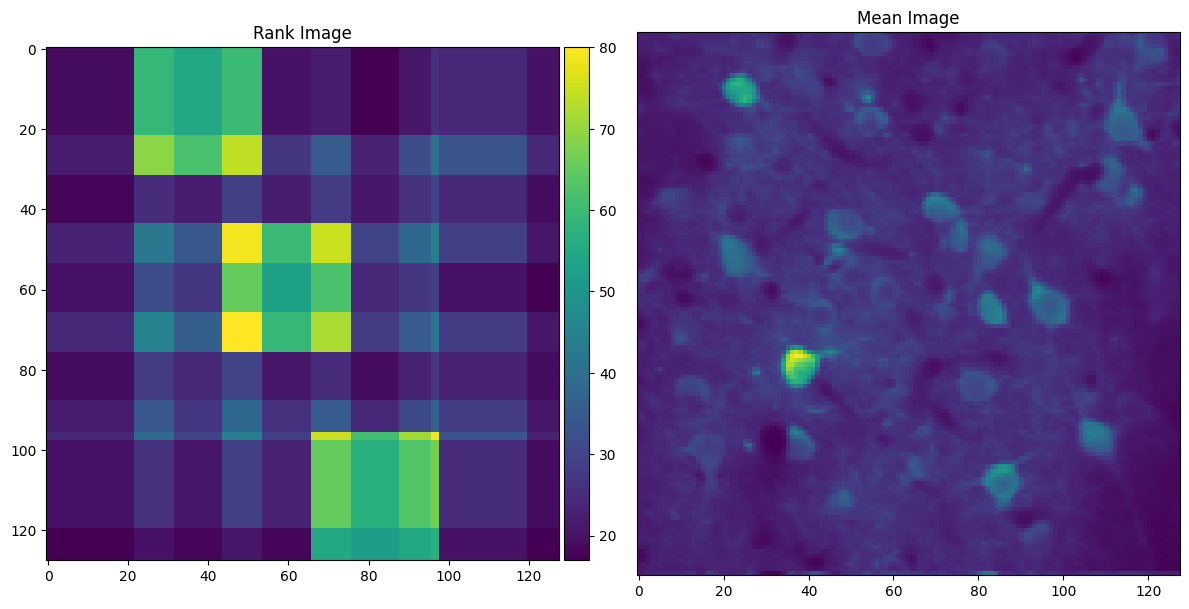

In [9]:
#@markdown #(Optional) Visualize rank plot of decomposition
def plot_rank_plot(data):
  import matplotlib.pyplot as plt
  from mpl_toolkits.axes_grid1 import make_axes_locatable
  import scipy
  import scipy.sparse
  U_sparse = scipy.sparse.csr_matrix(
          (data['U_data'], data['U_indices'], data['U_indptr']),
          shape=data['U_shape']
      ).tocoo()

  order = data.get('fov_order', np.array("C")).item()
  U = np.array(U_sparse.todense())
  shape = data['U_shape']
  d1,d2 = data['fov_shape']
  R = data['R']
  s = data['s']
  Vt = data['Vt']
  T = Vt.shape[1]
  V_full = R.dot(s[:, None] *Vt)
  V = V_full
  dims = (d1, d2, T)
  U_r = U.reshape((d1, d2,-1), order=order)

  mean_img = data['mean_img']

  U_r_bin = U_r != 0

  sum_U_r_bin = np.sum(U_r_bin, axis = 2)

  fig, ax = plt.subplots(1, 2, figsize=(12, 10))
  im = ax[0].imshow(sum_U_r_bin)
  ax[0].set_title("Rank Image")
  divider = make_axes_locatable(ax[0])
  cax = divider.append_axes("right", size="5%", pad=0.05)
  plt.colorbar(im, cax=cax)

  ax[1].imshow(data['mean_img'])
  ax[1].set_yticks([])
  ax[1].set_title("Mean Image")
  plt.tight_layout()
  save_output = os.path.join(data_folder, "RankPlot.png")
  plt.savefig(save_output)
  plt.show()

decomp_file = os.path.join(data_folder, "decomposition.npz")
data = np.load(decomp_file, allow_pickle=True)  
plot_rank_plot(data)

#MaskNMF Documentation: Define parameters for initializing neural network model + maskNMF algorithm Parameter documentation: 

1. **confidence**: Float between 0 and 1. The Mask R-CNN network identifies objects with varying levels of confidence. This parameter specifies a value between 0 and 1 which serves as a threshold: we only consider components that are identified with a confidence level above this threshold. We have found that a confidence level of 0.7 works well across a wide variety of data. 

2. **allowed_overlap**: Nonnegative integer. In a given frame of data, the Mask R-CNN might identify two objects that overlap. If these objects overlap by more than "allowed_overlap" pixels, we do not consider either of the objects. 

3. **block_dims_x, block_dims_y**: Positive Integers. We break the FOV into local subregions, and we run Mask R-CNN on the brightest frames of these subregions to identify cells. This procedure avoids the issue where the overall FOV has a huge brightness variation, and by looking at the brightest frames, we introduce a bias towards identifying components only located in a single part of the FOV. We partition the FOV into (block_dims_x, block_dims_y)-sized rectangles, find the brightest frames in each of these subregions, and run maskrcnn on these frames instead. 

4. **frame_len**: Positive Integer. In each subregion of the FOV (described above), we run Mask R-CNN at the "frame_len" brightest frames of the deconvolved movie. 

5. **spatial_thresholds_1, spatial_thresholds_2**: When we run Mask R-CNN on many frames, we may identify the same neuron many times. To deal with this issue, we take the final collection of neuron shapes identified by Mask R-CNN and filter them. We do so via two spatial thresholds. If the binary image of two shapes has a cosine similarity above spatial_thresholds_1, we discard one of the shapes. If the (non-binarized) fluorescence images between two shapes ahve a cosine similarity above spatial_thresholds_2, we discard one of the shapes. In general, setting a lower value for these parameters will allow the algorithm to identify more components. The default value, 0.3 and 0.3 works well across a variety of datasets. 

In [16]:
#@markdown #Step 1 Set MaskNMF parameters and run pipeline (documentation in the cell above)
# %%capture


#NOTE: this data folder will also contain the location of the TestData
data_folder = outdir

## @markdown #Step 2 MaskNMF: Set parameter values for initializing the neural network (see documentation below)

#Specify related parameters: 
confidence = 0.5 #@param {type:"slider", min:0, max:1, step:0.01}
allowed_overlap = 70 #@param {type:"slider", min:0, max:300, step:10}
cpu_only = False #Whether to run net on CPU (very slow) or GPU
# order = order #The default ordering of PMD outputs, specified in a previous block




## @markdown #Step 3 MaskNMF: Specify the key parameter values for Mask R-CNN detection of neural signals (see documentation above)

##PARAMETERS
block_dims_x = 20 #@param {type:"slider", min:5, max:200, step:1}
block_dims_y = 20 #@param {type:"slider", min:5, max:200, step:1}
frame_len = 200 #@param {type:"slider", min:5, max:2000, step:5}
#In each local spatial patch, we look at the "frame_len"-th brightest frames

'''When we filter our large list of neurons, we use these 
thresholds to discard similar neurons (to avoid over initializing the same cell)
'''
spatial_thresholds_1 = 0.3 #@param {type:"slider", min:0, max:1, step:0.01}
spatial_thresholds_2 = 0.3 #@param {type:"slider", min:0, max:1, step:0.01}

spatial_thresholds = [spatial_thresholds_1, spatial_thresholds_2]



def run_masknmf(data_folder, input_file, confidence, allowed_overlap, cpu_only,\
                block_dims_x, block_dims_y, frame_len, spatial_thresholds):

  import torch
  import torch_sparse
  import sys

  import copy
  #Misc imports
  import matplotlib.pyplot as plt
  import matplotlib.cm as cm
  import matplotlib as mpl
  import colorsys
  from matplotlib import patches,  lines
  from matplotlib.patches import Polygon
  import shutil
  import time
  import os
  import matplotlib.pyplot as plt
  import numpy as np
  from skimage import io
  import skimage
  from skimage import measure
  from skimage import filters

  import random
  import numpy as np
  import os
  import skimage.io as io

  import torch_sparse

  import scipy
  import scipy.sparse

  #Ring-LocalNMF specific imports
  from localnmf import superpixel_analysis_ring


  import boto3
  from botocore.config import Config
  from botocore import UNSIGNED

  from masknmf.engine.segmentation import segment_local_UV, filter_components_UV
  from masknmf.detection.maskrcnn_detector import maskrcnn_detector

  input_file = os.path.join(data_folder, "decomposition.npz")

  data = np.load(input_file, allow_pickle=True)

  U_sparse = scipy.sparse.csr_matrix(
          (data['U_data'], data['U_indices'], data['U_indptr']),
          shape=data['U_shape']
      ).tocoo()

  order = data.get('fov_order', np.array("C")).item()
  U = np.array(U_sparse.todense())
  shape = data['U_shape']
  d1,d2 = data['fov_shape']
  R = data['R']
  s = data['s']
  Vt = data['Vt']
  T = Vt.shape[1]
  V_full = R.dot(s[:, None] *Vt)
  V = V_full
  dims = (d1, d2, T)
  U_r = U.reshape((d1, d2,-1), order=order)


  #This is where we create the neural network
  dir_path = "neuralnet_info" 

  #Specify where to save these outputs
  MASK_NMF_CONFIG = os.path.join(dir_path, "config_nn.yaml")
  MASK_NMF_MODEL = os.path.join(dir_path, "model_final.pth")

  #Specify where to retrieve the neural net data. In this case, in the apasarkar-public bucket on AWS S3
  bucket_loc = "apasarkar-public"
  config_file_name = "config.yaml"
  weights_file_name = "model_final.pth"



  if not os.path.isdir("neuralnet_info"):
      os.mkdir("neuralnet_info")
      

  s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
  s3.download_file(bucket_loc,
                  config_file_name,
                  MASK_NMF_CONFIG)
  s3.download_file(bucket_loc,
                  weights_file_name,
                  MASK_NMF_MODEL)



  model = maskrcnn_detector(MASK_NMF_MODEL,
                                MASK_NMF_CONFIG,
                                confidence,
                                allowed_overlap,
                                cpu_only, order=order)

  temporal_components = data.get('deconvolved_temporal')
  mixing_weights = data['R']

  ##END OF PARAMETER DEFINITION



  if temporal_components is None:
      raise ValueError("Deconvolution was not run on this PMD output. Re-run PMD with deconv")


  # Run Detection On Select Frames
  print("Performing MaskRCNN detection...")
  bin_masks, footprints, properties, _ = segment_local_UV(
      U_sparse,
      mixing_weights,
      temporal_components,
      tuple((d1, d2, temporal_components.shape[-1])),
      model,
      frame_len,
      block_size=(block_dims_x, block_dims_y),
      order=order
  )

  print("Filtering detected components...")
  keep_masks = filter_components_UV(
          footprints, bin_masks, properties,
          spatial_thresholds[0], spatial_thresholds[1])
  print(f"Filtering completed {keep_masks.shape} of {np.count_nonzero(keep_masks)} components retained")

  a_dense = np.asarray(footprints[:, keep_masks].todense())
  a = a_dense.reshape((d1, d2, -1), order=order)

  return a

try: 

  import torch
  import jax
  torch.cuda.empty_cache()
  jax.clear_backends()


  a = run_masknmf(data_folder, input_file, confidence, allowed_overlap, cpu_only,\
                block_dims_x, block_dims_y, frame_len, spatial_thresholds)
  


  torch.cuda.empty_cache()
  jax.clear_backends()

except KeyboardException:
  display("\n \n \n")
  display("-------- ERROR GENERATED----------")
  display("The user manually ended the program execution. Please re-run this code block.")
  import torch
  import jax
  torch.cuda.empty_cache()
  jax.clear_backends()
  display("Memory Cleared, Ready to Re-Run")
except:
  display("\n \n \n")
  display("-------- ERROR GENERATED----------")
  display("Miscellaneous Error, please try to re-run.")
  import torch
  import jax
  torch.cuda.empty_cache()
  jax.clear_backends()
  display("Memory Cleared, Ready to Re-Run")


Performing MaskRCNN detection...
identifying bright regions took 7.848418712615967
bright regions identified. starting segmentation
now populating valid positions
the time taken to run maskrcnn on 50 frames is 1.0105516910552979
the time taken to run maskrcnn on 50 frames is 0.8524472713470459
the time taken to run maskrcnn on 50 frames is 0.8839414119720459
the time taken to run maskrcnn on 50 frames is 0.8785955905914307
the time taken to run maskrcnn on 50 frames is 0.9935495853424072
the time taken to run maskrcnn on 50 frames is 0.8800358772277832
the time taken to run maskrcnn on 50 frames is 0.8777611255645752
the time taken to run maskrcnn on 50 frames is 0.8763031959533691
the time taken to run maskrcnn on 50 frames is 0.8628885746002197
the time taken to run maskrcnn on 50 frames is 0.8624989986419678
the time taken to run maskrcnn on 50 frames is 0.8668913841247559
the time taken to run maskrcnn on 50 frames is 0.8723771572113037
the time taken to run maskrcnn on 50 frames i

In [12]:
#@markdown #Step 2 MaskNMF: Visualize identified cells via mean images; compare to variance image. Note: if maskNMF has identified fewer cells than expected, re-run maskNMF (above) after increasing frame_len.
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

import scipy
import scipy.ndimage

def get_a_halos(a):
  a_halos = np.zeros_like(a)
  for k in range(a.shape[2]):
    a_halos[:, :, k]= scipy.ndimage.distance_transform_bf(scipy.ndimage.distance_transform_bf(a[:, :, k]))
    
  return a_halos == 1


decomp_load= np.load(os.path.join(data_folder, "decomposition.npz"))



def plot_img(data_img, img, x1, length, y1, height):
    fix, ax = plt.subplots(2,2, figsize=(8, 8))
    rect = patches.Rectangle((x1, y1), length, height, linewidth=1, edgecolor='r', facecolor='none')
    ax[0,0].imshow(img)
    ax[0,0].add_patch(rect)
    ax[0,0].set_title("Identified ROIs".format(x1, length, y1, height))
    ax[0, 0].set_xticks([])

    rect2 = patches.Rectangle((x1, y1), length, height, linewidth=1, edgecolor='r', facecolor='none')  
    ax[1,0].imshow(data_img)
    ax[1,0].add_patch(rect2)
    ax[1,0].set_title("Denoised Data Mean Image")



    if length == 0 or height == 0:
      cropped_ROI_signals = img
      cropped_ROI_denoised = data_img
    else:
      cropped_ROI_signals = img[y1:(y1+height), x1:(x1+length)]
      cropped_ROI_denoised = data_img[y1:(y1+height), x1:(x1+length)]

    ax[0,1].imshow(cropped_ROI_signals)
    ax[0,1].set_title("Cropped Signal Estimates")
    ax[0,1].set_xticks([])
    ax[0,1].set_yticks([])

    ax[1,1].imshow(cropped_ROI_denoised)
    ax[1, 1].imshow(cropped_ROI_signals, cmap='jet', alpha=0.2)
    ax[1,1].set_title("ROIs and Mean Image Overlay")
    ax[1,1].set_xticks([])
    ax[1,1].set_yticks([])
    plt.show()

give = 2
a_used_vis = get_a_halos(a)
a_mean_img = np.mean(a_used_vis, axis = 2)
img_2 = a_mean_img > 0
img_1 = decomp_load['mean_img']
interact(plot_img, data_img = fixed(img_1), img=fixed(img_2), x1=widgets.IntSlider(min=0, max=img_1.shape[1] - give, step=1, value=0), \
         length=widgets.IntSlider(min=0, max=img_1.shape[1], step=1, value=0), y1=widgets.IntSlider(min=0, max=img_1.shape[1] - give, step=1, value=0), \
         height=widgets.IntSlider(min=0, max=img_1.shape[0], step=1, value=0))


interactive(children=(IntSlider(value=0, description='x1', max=278), IntSlider(value=0, description='length', …

<function __main__.plot_img(data_img, img, x1, length, y1, height)>

# DOCUMENTATION: Here we define parameters for NMF demixing algorithm and run demixing. We provide option to modify some parameters

1. num_passes. Positive Integer, at least 1. Number of passes which we run the NMF algorithm. In each pass, we take all signal identified by previous passes and subtract it from the video. Then, we run the superpixels initialization algorithm from localNMF to identify remaining signal. Finally, we regress all of the signals onto the PMD-denoised video. 

2. **pass_2_superpixels_corr_threshold**: Float between 0 and 1. If we run multiple NMF passes (i.e. num_passes > 1), then this parameter tells us the correlation threshold used to identify neurons in the second pass of NMF. 

3. **pass_3_superpixels_corr_threshold**: Float between 0 and 1. If we run multiple NMF passes (i.e. num_passes > 1), then this parameter tells us the correlation threshold used to identify neurons in the third pass of NMF. 

4. **pass_4_superpixels_corr_threshold**: Float between 0 and 1. If we run multiple NMF passes (i.e. num_passes > 1), then this parameter tells us the correlation threshold used to identify neurons in the fourth pass of NMF.

5. **corr_th_fix**: Float between 0 and 1. During the NMF algorithm, we expand (or contract) the shapes of neural signals based on this correlation threshold. Increase it to "shrink" the spatial support. 

6. **switch_point**: Positive integer. For each NMF pass, for the first "switch_point" updates, we use corr_th_fix. After the "switch_point"-th update, we use a different correlation value, corr_th_fix_sec (described next)

7. **corr_th_fix_sec**: Float between 0 and 1. During the NMF algorithm, we expand (or contract) the shapes of neural signals based on this correlation threshold. Increase it to "shrink" the spatial support.

8. **corr_th_del**: Float between 0 and 1. For each neural signal, if its correlation image is below this threshold, we delete the signal from our NMF algorithm and proceed. This is used to prune bad signal estimates (or redundant signal estimates). 

9. **merge_corr_thr**: Float betweeen 0 and 1. During NMF, the algorithm merges components together to deal with oversplitting. Two signals are merged if they have extremely high temporal correlations and spatial similarities. This parameter is the threshold for temporal similarity in this process. 

10. **merge_overlap_thr**: Float between 0 and 1. Building on parameter 9, this is the spatial correlation threshold for merging neurons. 

11. **r**: We use a modified version of the ring model described in CNMF-E to estimate neuropil during the NMF algorithm. This parameter describes the ring radius. It should roughly be as large as the radius of a soma in an imaging video. 


In [5]:
#@markdown #Step 1 NMF Demixing: Specify key parameters for the NMF demixing stage
import torch
torch.cuda.empty_cache()
import jax
jax.clear_backends()

import localnmf 
from localnmf import superpixel_analysis_ring
#This specifies the number of times we run the NMF algorithm on the data. If num_passes = 2 that means we run it once on the PMD data, then subtract the signals and 
#re-run on the residual
num_passes = 1 #@param {type:"slider", min:1, max:4, step:1}
init=['lnmf' for i in range(num_passes)]
init[0] = 'custom'

#This is the data structure we use to pass the data into the dictionary
custom_init = dict()
custom_init['a'] = a

# pass_1 = 0.9 #@param {type:"slider", min:0.01, max:1, step:0.01}
pass_2_superpixels_corr_threshold = 0.75 #@param {type:"slider", min:0.01, max:1, step:0.01}
pass_3_superpixels_corr_threshold = 0.9 #@param {type:"slider", min:0.01, max:1, step:0.01}
pass_4_superpixels_corr_threshold  = 0.86 #@param {type:"slider", min:0.01, max:1, step:0.01}
cut_off_point=[0.9, pass_2_superpixels_corr_threshold,pass_3_superpixels_corr_threshold, pass_4_superpixels_corr_threshold]
length_cut=[3, 5, 2, 2]
th=[2, 2, 2, 2]
pass_num = num_passes

corr_th_fix=0.55 #@param {type:"slider", min:0.01, max:1, step:0.01}
switch_point = 5 #@param {type:"slider", min:1, max:30, step:1}
corr_th_fix_sec = 0.7 #@param {type:"slider", min:0.01, max:1, step:0.01}
corr_th_del = 0.2 #@param {type:"slider", min:0.01, max:1, step:0.01}

max_allow_neuron_size=0.15
merge_corr_thr=0.7 #@param {type:"slider", min:0.01, max:1, step:0.01}
merge_overlap_thr=0.7 #@param {type:"slider", min:0.01, max:1, step:0.01}
r = 20 #@param {type:"slider", min:5, max:50, step:1}




##Do not need to modify
residual_cut = [0.5, 0.6, 0.6, 0.6]
num_plane=1
patch_size=[100,100]
plot_en = False
TF=False
fudge_factor=1
text=True
max_iter=30
init=init #lnmf specifies superpixel init
max_iter_fin= 30 #Normally 30
update_after= 10
pseudo_1 = [0, 0, 0, 0]
pseudo_2 = [1/20, 1/20,1/15, 0]
skips=0
update_type = "Constant" #Options here are 'Constant' or 'Full'
custom_init = custom_init
block_dims = None
confidence = None
spatial_thres = None
frame_len = None
model=None
allowed_overlap = 40
plot_mnmf = False
sb = True
pseudo_corr = [0, 0, 3/4, 3/4]
plot_debug = False
denoise = [False for i in range(max_iter)]
for k in range(max_iter):
  if k > 0 and k % 20 == 0:
    denoise[k] = True
batch_size = 100
device = 'cuda'


import scipy
data_folder = outdir
input_file = os.path.join(data_folder, "decomposition.npz")
data = np.load(input_file, allow_pickle=True)
U_sparse = scipy.sparse.csr_matrix(
        (data['U_data'], data['U_indices'], data['U_indptr']),
        shape=data['U_shape']
    ).tocoo()
order = data.get('fov_order', np.array("C")).item()
# U = np.array(U_sparse.todense())
shape = data['U_shape']
d1,d2 = data['fov_shape']
R = data['R']
s = data['s']
Vt = data['Vt']
T = Vt.shape[1]
V = R.dot(s[:, None] *Vt)
dims = (d1, d2, T)
U_r = np.array(U_sparse.todense()).reshape((d1, d2,-1), order=order)

# %load_ext line_profiler 
try:

  import torch
  torch.cuda.empty_cache()
  import jax
  jax.clear_backends()
  import localnmf
  from localnmf import superpixel_analysis_ring
  rlt = superpixel_analysis_ring.demix_whole_data_robust_ring_lowrank(U_r,\
                                V,r, cut_off_point,\
                                    length_cut, th, pass_num,\
                                    residual_cut, corr_th_fix,\
                                      corr_th_fix_sec, corr_th_del, switch_point,\
                                    max_allow_neuron_size, merge_corr_thr,\
                                    merge_overlap_thr, num_plane,\
                                    patch_size, plot_en, TF, \
                                    fudge_factor, text, max_iter,\
                                    max_iter_fin, update_after, \
                                    pseudo_1, pseudo_2, skips, update_type, init=init,\
                                    block_dims=block_dims, frame_len=frame_len,\
                                    confidence=confidence, spatial_thres=spatial_thres,\
                                                      model=model,custom_init=custom_init,\
                                                                allowed_overlap=allowed_overlap, \
                                                                      plot_mnmf = plot_mnmf,\
                                                                      sb=sb, pseudo_corr = pseudo_corr, plot_debug = plot_debug,\
                                                                    denoise = denoise, device = device, batch_size = batch_size)


  display("Clearing memory from run")
  import torch
  torch.cuda.empty_cache()
  import jax
  jax.clear_backends()

  del U_r
  del V
  del U_sparse
except Exception as e:
  display(e)
  del U_r
  del V
  del U_sparse
  display("Error Generated")
  import torch
  torch.cuda.empty_cache()
  import jax
  jax.clear_backends()


the original shape of U and V is (16384, 307) and (307, 1230)
the shape of col_count is (307,)
the new shapes of U and V are (16384, 307) and (307, 1230)
BEFORE MIN SUB we have U is (128, 128, 307) and V is (307, 1230)
Orthogonalizing UV
Orthogonalization took 0.006369352340698242
start 1 pass!
start 1 pass iteration!
pre update AC
BEFORE ENTERINIG DEMIX THE PATCH SIZE IS [100, 100]
the patch size is (128, 128)
MASK IS NOT NONE
Resid Corr Image Took 0.46230101585388184
Standard Corr Image Took 0.0995173454284668
shape of corr_img_all_r is (128, 128, 21)
number of elts in ring is 124
the max of good components is True
time: 0.09023189544677734
time: 0.08237004280090332
time: 0.08146262168884277
time: 0.08121728897094727
time: 0.08136868476867676
time: 0.08029055595397949
time: 0.08096933364868164
time: 0.08044219017028809
time: 0.08017516136169434
making dynamic support updates
merging components
no merge!
time: 0.6869680881500244
time: 0.08179426193237305


/data/home/app2139/anaconda3/envs/masknmf_full_pipeline/lib/python3.9/site-packages/torch_sparse/storage.py:14: UserWarning: `layout` argument unset, using default layout "coo". This may lead to unexpected behaviour.
  warnings.warn('`layout` argument unset, using default layout '


time: 0.08215737342834473
time: 0.08190417289733887
time: 0.08187270164489746
time: 0.08234214782714844
time: 0.08142328262329102
time: 0.08244132995605469
time: 0.08179306983947754
time: 0.08144640922546387
making dynamic support updates
merging components
no merge!
time: 0.6819047927856445
time: 0.13701653480529785
time: 0.08297276496887207
time: 0.08266830444335938
time: 0.08345198631286621
time: 0.08369064331054688
time: 0.08282661437988281
time: 0.08318543434143066
time: 0.08311963081359863
time: 0.08279919624328613
making dynamic support updates
merging components
no merge!
time: 0.6825680732727051
time: 4.973177433013916
POST update AC
time: 7.152557373046875e-07
[22-12-15 01:50:28]: Clearing memory from run


In [10]:
#@markdown #Save the results of demixing the data
fin_rlt = rlt['fin_rlt']
a_dv = fin_rlt['a'].reshape((d1, d2, -1), order="F")
c = fin_rlt['c'].T
W = fin_rlt['W']
b = fin_rlt['b'] #static background
b_r = b.reshape((d1, d2, 1), order=order)

rlt_save_path = os.path.join(data_folder, "components.npz")

np.savez(rlt_save_path, a=a_dv, c=c, W=W, b_r = b_r, allow_pickle=True)

In [9]:
from localnmf.superpixel_analysis_ring import get_min_vals
import localnmf
from localnmf import visualization

U_sparse = scipy.sparse.csr_matrix(
        (data['U_data'], data['U_indices'], data['U_indptr']),
        shape=data['U_shape']
    ).tocoo()
shape = data['U_shape']
d1,d2 = data['fov_shape']
R = data['R']
s = data['s']
Vt = data['Vt']
T = Vt.shape[1]
V = s[:, None] *Vt
dims = (d1, d2, T)
order = data.get('fov_order', np.array("C")).item()

device_disp = 'cuda'

def normalize_pixels_test(mat):
    d1, d2 = mat.shape[0], mat.shape[1]
    min_mat = np.zeros((d1, d2, 1))
    max_mat = np.zeros((d1, d2, 1))
    
    min_mat += np.amin(mat, axis = 2, keepdims=True)
    mat -= min_mat
    
    max_mat += np.amax(mat, axis = 2, keepdims=True)
    max_mat[max_mat == 0] = 1
    
    mat /= max_mat
    
    return mat


def eliminate_large_values(mat, percentile_thres = 99):
    val = np.percentile(mat, percentile_thres)
    mat[mat > val] = val 
    
    return mat

fin_rlt = rlt['fin_rlt']
a_dv = fin_rlt['a'].reshape((d1, d2, -1), order="F") ##ORIGINALLY IT WAS order = order, but order = "F" makes more sense, since it has nothing to do with the PMD ordering, only with ring localnmf ordering
c = fin_rlt['c'].T
W = fin_rlt['W'].tocsr()
b = fin_rlt['b']
b_r = b.reshape((d1, d2, 1), order="F") ##ORIGINALLY IT WAS order = order, but order = "F" makes more sense, since it has nothing to do with the PMD ordering, only with ring localnmf ordering

start = 0
end = 500


### ESTIMATE THE STANDARD DEVIATION OF THE DATA
# std_img = get_std_img(U_sparse, R, V, (d1, d2), order, sample_size=1000)
# zeros_vec = np.zeros((1, end - start))
# std_img = std_img + zeros_vec
### 

##Define the a and c components: 
c_crop = c[:, start:end]

mov_denoised_min = get_min_vals(U_sparse, R.dot(V), device=device_disp)
mov_denoised = U_sparse.dot(R.dot(V[:, start:end])) - mov_denoised_min
mov_denoised = mov_denoised.reshape((d1, d2, -1), order=order)



inv = U_sparse.transpose().dot(U_sparse)
inv = np.array(inv.todense())
inv = np.linalg.inv(inv)

UW = U_sparse.transpose().dot(W)
inv_UW = (UW.transpose().dot(inv.T)).T

comp_temp = mov_denoised.reshape((d1*d2, -1), order=order) - a_dv.reshape((d1*d2, -1), order=order).dot(c_crop) - b
comp_2 = inv_UW.dot(comp_temp)
comp_1 = U_sparse

background_est = (comp_1.dot(comp_2))
new_background_est = W.dot(background_est)



new_background_est = new_background_est.reshape((d1, d2, -1), order=order)
background_est = background_est.reshape((d1, d2, -1), order=order)

difference_movie = new_background_est - background_est


new_background_est = normalize_pixels_test(new_background_est)
background_est = normalize_pixels_test(background_est)




# difference_movie = comp_temp.reshape((d1, d2, -1), order=order) - background_est

mov_list = [difference_movie, background_est]
filename = "BG_Ring_Model_All_Frames"
titles = ["W*B_f - B_f", "B_f"]
img_types = [1,1]
movie_scales = [100, 100]

localnmf.visualization.write_mpl_no_compress_comparisons(mov_list, 
              filename, img_types, movie_scales,
              fr=30, 
              titles=titles, scale=1, titlesize=20, ticksize=14, colorticksize=12, width_const = 10, offset = 0)


the CPU affinity BEFORE runpar is 24
the number of processes is 24
pid 26559's current affinity list: 0
pid 26559's new affinity list: 0-23
pid 26560's current affinity list: 0
pid 26560's new affinity list: 0-23
pid 26562's current affinity list: 0
pid 26562's new affinity list: 0-23
pid 26563's current affinity list: 0
pid 26563's new affinity list: 0-23
pid 26564's current affinity list: 0
pid 26564's new affinity list: 0-23
pid 26567's current affinity list: 0
pid 26567's new affinity list: 0-23
pid 26569's current affinity list: 0
pid 26569's new affinity list: 0-23
pid 26571's current affinity list: 0
pid 26571's new affinity list: 0-23
pid 26572's current affinity list: 0
pid 26572's new affinity list: 0-23
pid 26574's current affinity list: 0
pid 26574's new affinity list: 0-23
pid 26575's current affinity list: 0
pid 26575's new affinity list: 0-23
pid 26576's current affinity list: 0
pid 26576's new affinity list: 0-23
pid 26578's current affinity list: 0
pid 26578's new affi

ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libsw

In [6]:
#@markdown #Visualization 1: Generate demixing video to inspect results. 

from localnmf.superpixel_analysis_ring import get_min_vals
from localnmf.visualization import write_mpl_no_compress_comparisons
import torch_sparse

def generate_color_movie(a_use, c_use, dims, random_values, seed=999):
    '''
    Function generates a demixing video in which each neuron is assigned its own color
    args:
        a_use: ndarray. Dimensions (d1, d2, K). Provides the spatial footprints of K neurons over a (d1 x d2)-pixel field of view
        c_use: ndarray, (K, T). Provides temporal traces of K neurons over a T-frame video
        dims: tuple, (x,y). Provides dimensions of video (x * y = d)
        random_values: random color values assigned to each neural signal in the color movie
        seed: int. Seed for random color generation. Set this to make random generation deterministic
    '''
    import random
    np.random.seed(seed) #seed for random color generation (to keep it consistent if desired)
    final_movie = np.zeros((dims[0], dims[1], 3, c_use.shape[1])) #z is number of planes, and 3 is because we use RGB data
    
    
    sum_random_values = np.sum(random_values, axis = 1, keepdims = True)
    random_color_norm = random_values / sum_random_values
    
    c_color = np.zeros((c_use.shape[0], 3, c_use.shape[1]))
    for i in range(3):
        c_color[:, i, :] = random_color_norm[:, [i]] * c_use
        
    final_movie = np.tensordot(a_use, c_color, axes = (2,0))
    max_val = np.amax(final_movie)
    if max_val != 0:
        final_movie = final_movie / np.amax(final_movie) #Now it is back to 0 -- 1
    return final_movie.squeeze()


def get_std_img(U_sparse, R, V, dims, order, sample_size = 1000):
    random_indices = np.random.choice([i for i in range(T)], size = 1000, replace=False)
    V_sampled = torch.from_numpy(V[:, random_indices]).to(device_disp)
    R_torch = torch.from_numpy(R).to(device_disp)
    U_sparse_torch = torch_sparse.tensor.from_scipy(U_sparse).to(device_disp)
    RV_sampled = torch.matmul(R_torch, V_sampled)
    URV_sampled = torch_sparse.matmul(U_sparse_torch, RV_sampled)

    std_img = torch.std(URV_sampled, dim=1, keepdim=True).cpu().numpy()
    std_img = std_img.reshape((dims[0], dims[1], 1), order = order)

    return std_img


start = 0 #@param {type:"slider", min:0, max:100000, step:1}
end = 500 #@param {type:"slider", min:0, max:100000, step:1}
filename = "DemixingVideo" #@param {type:"string"}

if end < start: 
  print("Error: You set a start value greater than the end value. Using default params instead.")
  start = 0
  end = 100
dim1_range = [0, 512]
dim2_range = [0, 512]
device_disp = 'cuda'

U_sparse = scipy.sparse.csr_matrix(
        (data['U_data'], data['U_indices'], data['U_indptr']),
        shape=data['U_shape']
    ).tocoo()
shape = data['U_shape']
d1,d2 = data['fov_shape']
R = data['R']
s = data['s']
Vt = data['Vt']
T = Vt.shape[1]
V = s[:, None] *Vt
dims = (d1, d2, T)
order = data.get('fov_order', np.array("C")).item()


### ESTIMATE THE STANDARD DEVIATION OF THE DATA
std_img = get_std_img(U_sparse, R, V, (d1, d2), order, sample_size=1000)
zeros_vec = np.zeros((1, end - start))
std_img = std_img + zeros_vec
### 


mov_denoised_min = get_min_vals(U_sparse, R.dot(V), device=device_disp)
mov_denoised = U_sparse.dot(R.dot(V[:, start:end])) - mov_denoised_min
mov_denoised = mov_denoised.reshape((d1, d2, -1), order=order)

fin_rlt = rlt['fin_rlt']
a_dv = fin_rlt['a'].reshape((d1, d2, -1), order="F") ##ORIGINALLY IT WAS order = order, but order = "F" makes more sense, since it has nothing to do with the PMD ordering, only with ring localnmf ordering
c = fin_rlt['c'].T
W = fin_rlt['W'].tocsr()
b = fin_rlt['b']
b_r = b.reshape((d1, d2, 1), order="F") ##ORIGINALLY IT WAS order = order, but order = "F" makes more sense, since it has nothing to do with the PMD ordering, only with ring localnmf ordering


##Define the a and c components: 
c_crop = c[:, start:end]

##Define the fluctuating backgound components
inv = U_sparse.transpose().dot(U_sparse)
inv = np.array(inv.todense())
inv = np.linalg.inv(inv)

UW = U_sparse.transpose().dot(W)
inv_UW = (UW.transpose().dot(inv.T)).T

comp_2 = mov_denoised.reshape((d1*d2, -1), order=order) - a_dv.reshape((d1*d2, -1), order=order).dot(c_crop) - b
comp_2 = inv_UW.dot(comp_2)
comp_1 = U_sparse
# comp_1 = W
# comp_2 = mov_denoised.reshape((d1*d2, -1), order=order) - a_dv.reshape((d1*d2, -1), order=order).dot(c_crop) - b



movie_scales = [100, 100, 100, 100, 100, 100]

localnmf.visualization.standard_demix_vid(a_dv, c_crop, b_r, mov_denoised, (comp_1, comp_2),deviation_img =std_img, \
                                 filename = filename,fr=90, scale = 1, width_const=3, \
                                start = start, end = end, movie_scales=movie_scales, \
                                 dim1_range = dim1_range, dim2_range = dim2_range, \
                                min_sub_signals=False)


import shutil 
final_destination = os.path.join(data_folder, filename+".mp4")
if os.path.isfile(final_destination):
  os.remove(final_destination)
  print("deleted file at location {} before moving the new demixing video of the same name to this location")
shutil.move(filename+ ".mp4", data_folder)
print("the demixing video is now available at {} in your google drive".format(os.path.join(data_folder, filename + ".mp4")))


the CPU affinity BEFORE runpar is 24
the number of processes is 24
pid 26309's current affinity list: 0
pid 26309's new affinity list: 0-23
pid 26310's current affinity list: 0
pid 26310's new affinity list: 0-23
pid 26312's current affinity list: 0
pid 26312's new affinity list: 0-23
pid 26313's current affinity list: 0
pid 26313's new affinity list: 0-23
pid 26314's current affinity list: 0
pid 26314's new affinity list: 0-23
pid 26317's current affinity list: 0
pid 26317's new affinity list: 0-23
pid 26319's current affinity list: 0
pid 26319's new affinity list: 0-23
pid 26318's current affinity list: 0
pid 26318's new affinity list: 0-23
pid 26321's current affinity list: 0
pid 26321's new affinity list: 0-23
pid 26323's current affinity list: 0
pid 26323's new affinity list: 0-23
pid 26324's current affinity list: 0
pid 26324's new affinity list: 0-23
pid 26326's current affinity list: 0
pid 26326's new affinity list: 0-23
pid 26325's current affinity list: 0
pid 26325's new affi

ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libsw

the demixing video is now available at /data/home/app2139/masknmf_full_pipeline/datasets/M1_267_EVEN_results_15_12_2022_01_33_29/DemixingVideo.mp4 in your google drive


frame=  500 fps= 24 q=31.0 Lsize=    3419kB time=00:00:05.54 bitrate=5051.1kbits/s speed=0.261x    
video:3416kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.088316%


In [16]:
#@markdown #Visualization 2: Look at cropped versions of mean image. Re-run above code accordingly.


from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
import torch_sparse
import torch
import scipy



def get_std_img(U_sparse, R, V, dims, order, sample_size = 1000, device_disp='cuda'):
    random_indices = np.random.choice([i for i in range(T)], size = 1000, replace=False)
    V_sampled = torch.from_numpy(V[:, random_indices]).to(device_disp)
    R_torch = torch.from_numpy(R).to(device_disp)
    U_sparse_torch = torch_sparse.tensor.from_scipy(U_sparse).to(device_disp)
    RV_sampled = torch.matmul(R_torch, V_sampled)
    URV_sampled = torch_sparse.matmul(U_sparse_torch, RV_sampled)

    std_img = torch.std(URV_sampled, dim=1, keepdim=True).cpu().numpy()
    std_img = std_img.reshape((dims[0], dims[1], 1), order = order)

    return std_img


def get_mean_img(rlt, data):
  d1, d2 = data['fov_shape']
  fin_rlt = rlt['fin_rlt']
  order = data.get('fov_order', np.array("C")).item()
  a = fin_rlt['a'].reshape((d1, d2, -1), order=order)
  c = fin_rlt['c'].T
  c_mean = np.mean(c, axis = 1, keepdims=True)
  mean_signal_image = np.tensordot(a, c_mean, axes=(2,0)).squeeze()
  return mean_signal_image

def get_std_img_from_data(data):
  U_sparse = scipy.sparse.csr_matrix(
          (data['U_data'], data['U_indices'], data['U_indptr']),
          shape=data['U_shape']
      ).tocoo()
  shape = data['U_shape']
  d1,d2 = data['fov_shape']
  R = data['R']
  s = data['s']
  Vt = data['Vt']
  T = Vt.shape[1]
  V = s[:, None] *Vt
  dims = (d1, d2, T)
  order = data.get('fov_order', np.array("C")).item()

  std_img = get_std_img(U_sparse, R, V, (d1, d2), order, sample_size=1000)
  return std_img

def get_noise_variance_image_data(data):
  return data['noise_var_img']

mean_signal_img = get_mean_img(rlt, data).squeeze()
std_img = get_std_img_from_data(data).squeeze()
# std_img = get_noise_variance_image_data(data)


def plot_img(data_img, img, x1, length, y1, height):
    fix, ax = plt.subplots(2,2, figsize=(8, 8))
    rect = patches.Rectangle((x1, y1), length, height, linewidth=1, edgecolor='r', facecolor='none')
    ax[0,0].imshow(img)
    ax[0,0].add_patch(rect)
    ax[0,0].set_title("Identified ROIs".format(x1, length, y1, height))
    ax[0, 0].set_xticks([])

    rect2 = patches.Rectangle((x1, y1), length, height, linewidth=1, edgecolor='r', facecolor='none')  
    ax[1,0].imshow(data_img)
    ax[1,0].add_patch(rect2)
    ax[1,0].set_title("Denoised Data Mean Image")



    if length == 0 or height == 0:
      cropped_ROI_signals = img
      cropped_ROI_denoised = data_img
    else:
      cropped_ROI_signals = img[y1:(y1+height), x1:(x1+length)]
      cropped_ROI_denoised = data_img[y1:(y1+height), x1:(x1+length)]

    ax[0,1].imshow(cropped_ROI_signals)
    ax[0,1].set_title("Cropped Signal Estimates")
    ax[0,1].set_xticks([])
    ax[0,1].set_yticks([])

    ax[1,1].imshow(cropped_ROI_denoised)
    ax[1,1].set_title("Cropped Denoised Mean Image")
    ax[1,1].set_xticks([])
    ax[1,1].set_yticks([])
    plt.show()

give = 2
interact(plot_img, data_img = fixed(std_img), img=fixed(mean_signal_img), x1=widgets.IntSlider(min=0, max=std_img.shape[1] - give, step=1, value=0), \
         length=widgets.IntSlider(min=0, max=std_img.shape[1], step=1, value=0), y1=widgets.IntSlider(min=0, max=std_img.shape[1] - give, step=1, value=0), \
         height=widgets.IntSlider(min=0, max=std_img.shape[0], step=1, value=0))

interactive(children=(IntSlider(value=0, description='x1', max=126), IntSlider(value=0, description='length', …

<function __main__.plot_img(data_img, img, x1, length, y1, height)>